In [30]:
import numpy as np
import pandas as pd

In [31]:
data=pd.read_excel("Manually_Tagged_Sheet.xlsx",sheet_name="Valid Entries_updated_15_06_202")
# data.head()
data=data.drop(columns=["exact_matched_patt","spacy_format_v1","spacy_format_v1","summaries_matching"])
data.columns=["id","summaries","exact_matched_patt_contextual","Tech_from_string_match"]

In [32]:
data=data.loc[:2500]
# data=data.sort_values(by=['id'])
# data=data.reset_index(drop=True)
# len(data)

In [33]:
train = data.loc[:2000]
test = data.loc[2001:]

In [34]:
len(train),len(test)

(2001, 500)

In [35]:
train.to_csv("Manual_TAGGED_2001_TRAIN.csv")
test.to_csv("Manual_TAGGED_500_TEST.csv")

In [36]:
data=train

In [37]:
#replacing null vals with empty list
data['exact_matched_patt_contextual'] = [ [] if x is np.NaN else x for x in data['exact_matched_patt_contextual'] ]


In [38]:
import nltk
import re
from bs4 import BeautifulSoup

nltk.download("punkt")

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    return text


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mohitbagaria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [39]:
# for i, l in enumerate(data["exact_matched_patt_contextual"]):
#  print("list",i,"is",type(l))

In [40]:
data['exact_matched_patt_contextual']=data['exact_matched_patt_contextual'].astype(str)

In [41]:
# for i, l in enumerate(data["exact_matched_patt_contextual"]):
#  print("list",i,"is",type(l))

In [42]:
# data.head(15)

In [43]:
def clean_alt_list(list_):
#     list_ = list_.replace(', ', "','")
#     list_ = list_.replace('[', "['")
#     list_ = list_.replace(']', "']")
    
    if(list_[0]!='['):
        list_='['+list_
    if(list_[len(list_)-1]!=']'):
        list_+=']'
    return list_


In [44]:
data["exact_matched_patt_contextual"] = data["exact_matched_patt_contextual"].apply(clean_alt_list)

In [45]:
data["exact_matched_patt_contextual"] = data["exact_matched_patt_contextual"].apply(eval)

In [50]:
tech_dict = {}
for i in data['exact_matched_patt_contextual']:
    for j in i:
        if j not in tech_dict:
            tech_dict[j] = 1
        else:
            tech_dict[j] += 1

# tech_dict

tech_list=[]
tech_multi_words=[]
for i in tech_dict:
    if ((' ' in i) == True):
        tech_multi_words.append(i)
    else:
        tech_list.append(i)

In [51]:
tech_multi_words.append('microsoft power point')
tech_multi_words.append('sap pm')
# tech_multi_words.append('sap erp')

In [52]:
len(tech_multi_words), len(set(tech_multi_words))

(308, 308)

In [53]:
print('pwc' in tech_list), 
print('ey' in tech_list), 
print('amazon' in tech_list),
print('flipkart' in tech_list),
print('microsoft' in tech_list),
print('sap' in tech_list),
print('ibm' in tech_list)

True
True
False
False
False
False
False


In [54]:
tech_list.append("amazon")
tech_list.append("flipkart")
tech_list.append("microsoft")
tech_list.append("sap")
tech_list.append("ibm")

In [22]:
# tech_multi_words[:5]

In [23]:
# tech_list[:5]

In [55]:
len(tech_list) , len(set(tech_list))

(1078, 1078)

In [56]:
data["summaries"]=data["summaries"].apply(clean_text)
data.summaries = data.summaries.replace('\s+', ' ', regex=True)

In [57]:
def find_all(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1: return
        yield start
        start += len(sub) # use start += 1 to find overlapping matches

In [58]:
def convert(lst):
    return ' '.join(lst).split()


def BIO_conversion(sentence):
    
    ind_dict = {}
    for i in tech_multi_words:
        if i in sentence:
#             ind_dict[sentence.index(i)]=i #word as val, key as index
            all_occ = list(find_all(sentence,i)) # [0, 5, 10, 15]
            for ind in all_occ:
                ind_dict[ind]=i

            
    temp_word=""
    final_word_sen=[]
    final_tag_sen = []
    start=-1
    end=-1
    for i in range(0, len(sentence)):
        if(i in range(start,end)):
#             print("break hua")
            continue
#         print(i)
        if sentence[i].isspace()==True and len(temp_word)>0:
            final_word_sen.append(temp_word)
            if temp_word in tech_list:
#                 print(temp_word)
                final_tag_sen.append("B")
            else:
                final_tag_sen.append("O")
            temp_word=""
        else: #not space
            try: #do we have multiword at this index
                temp_word=ind_dict[i]
#                 print("****")
                start=i+1
                end=i+len(temp_word) #here tag these multiwords and update new i
#                 print(i)
#                 print("****")
#                 print(temp_word)
                listofwords = convert([temp_word])
                f=True
                for word in listofwords:
                    final_word_sen.append(word)
                    if f:
                        final_tag_sen.append("B")
                        f=False
                    else:
                        final_tag_sen.append("I")
                temp_word=""
            except:
                if(sentence[i]!=' '):
                    temp_word+=sentence[i]
                
#     final_tag_sen.append(None) #adding blank
#     final_word_sen.append(None)#adding blank
#     print(len(sentence.split())-len(final_word_sen))
    return pd.DataFrame(list(zip(final_word_sen, final_tag_sen)),columns =['Word', 'Tag'])

In [59]:
# BIO_conversion(data["summaries"][18])

In [60]:
final_data=pd.DataFrame()

for i in range(0,len(data)):
      
    temp = BIO_conversion(data["summaries"][i])
    length = len(temp)
    wordd="Sentence :"+str(i+1) #sentence no.
    a=[wordd]*length
    temp.insert(0,"Sentence #",a)
    final_data = final_data.append(temp, ignore_index=True) #appending sentences in the required format

/Users/mohitbagaria/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


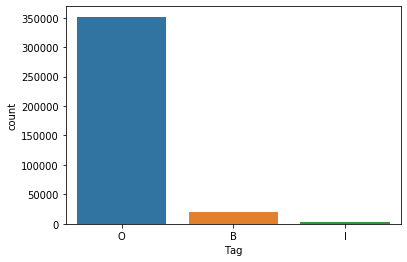

In [62]:
import seaborn as sns
sns.countplot(final_data['Tag'])

In [63]:
final_data['Tag'].value_counts()

O    351606
B     19351
I      3256
Name: Tag, dtype: int64

In [64]:
df=final_data
df.loc[(df['Tag'] == 'B'), 'Tag'] = 'B-ORG'
df.loc[(df['Tag'] == 'I'), 'Tag'] = 'I-ORG'
df.to_csv("2000_BIO_taggingdata_ALL.csv",index=False)

In [ ]:
data["summaries"][12]

In [ ]:
# df=final_data2
# df.loc[(df['Tag'] == 'B'), 'Tag'] = 'B-ORG'
# df.loc[(df['Tag'] == 'I'), 'Tag'] = 'I-ORG'
# df.to_csv("BIO_taggingdata_B_MUST.csv",index=False)